In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib.ticker as mticker
import geopy.distance

xl_file = "/Volumes/KeithSSD/CB_V4/otu_data/mixing_data/Particle_Data.xlsx"

assert os.path.exists(xl_file)
unformatted_df1 = pd.read_excel(xl_file, sheet_name='2015')
unformatted_df2 = pd.read_excel(xl_file, sheet_name='2016')

env_data_file = "/Volumes/KeithSSD/CB_V4/otu_data/WaterQualityData/matched_cleaned_data/all_mdata_with_habitat.txt"
env_data = pd.read_csv(env_data_file, sep="\t")
stat_latlon = env_data[['StationName', 'Latitude', 'Longitude']].groupby('StationName').agg('mean').round(3)
stat_latlon.head()

,Latitude,Longitude
StationName,,
CB22,39.349,-76.176
CB31,39.250,-76.240
CB32,39.164,-76.306
CB33C,38.998,-76.359
CB41C,38.826,-76.399


In [2]:
# prep df by add columns of station lat, lon, and depth*-1 to individual particle data
def prep_particle_chunk(sample_pt_i, sample_pts, stat_latlon, particle_data, index_range_i):
    one_sample = sample_pts.loc[sample_pt_i, :].to_dict()
    one_sample['StatLat'] = stat_latlon.loc[one_sample['StationName'], 'Latitude']
    one_sample['StatLon'] = stat_latlon.loc[one_sample['StationName'], 'Longitude']
    one_sample['DepthName'] *= -1
    origin_cols = pd.DataFrame({p_i: one_sample for p_i in index_range_i}).T
    one_section = particle_data.loc[index_range_i, :].copy()
    particle_sub = pd.concat((one_section, origin_cols), axis=1, sort=1, verify_integrity=1)
    return particle_sub.copy()


In [3]:
horiz_dist = lambda x: geopy.distance.distance((x[0], x[1]), (x[2], x[3])).km

def summarize_chunk(particle_sub):
    pos_cols = ['lat', 'lon', 'StatLat', 'StatLon']
    particle_sub['horiz_dist'] = particle_sub[pos_cols].apply(horiz_dist, axis=1)
    particle_sub['vert_dist'] = particle_sub['DepthName'] - particle_sub['depth']
    sub_summary = {}
    sub_summary['sum_horiz_dist'] = particle_sub['horiz_dist'].sum()
    sub_summary['sum_vert_dist'] = abs(particle_sub['vert_dist']).sum()
    sub_summary['sum_downwelling'] = particle_sub.loc[particle_sub.vert_dist < 0, 'vert_dist'].sum()
    sub_summary['sum_upwelling'] = particle_sub.loc[particle_sub.vert_dist > 0, 'vert_dist'].sum()
    sub_summary['north_lim'] = np.percentile(particle_sub.lat, 75) - particle_sub.StatLat.unique()[0]
    sub_summary['south_lim'] = np.percentile(particle_sub.lat, 25) - particle_sub.StatLat.unique()[0]
    sub_summary['east_lim'] = np.percentile(particle_sub.lon, 75) - particle_sub.StatLon.unique()[0]
    sub_summary['west_lim'] = np.percentile(particle_sub.lon, 25) - particle_sub.StatLon.unique()[0]
    sub_summary['up_lim'] = np.percentile(particle_sub.depth, 75) - particle_sub.DepthName.unique()[0]
    sub_summary['down_lim'] = np.percentile(particle_sub.depth, 25) - particle_sub.DepthName.unique()[0]
    return sub_summary


In [4]:
def summarize_particle_year(unformatted_df):
    # the first six columns are date time depth station collection agency 
    sample_pts = unformatted_df.iloc[: , :6].dropna()
    print(sample_pts.StationName.unique())
    print(sample_pts.head())
    # pull out this data and add the right column names 
    particle_data = unformatted_df.iloc[1:, 6:].dropna()
    particle_data.columns = ['y_km', 'x_km', 'lat', 'lon', 'depth']
    particle_data = particle_data.apply(pd.to_numeric, axis=1)
    # longitude is wrong
    particle_data['lon'] = particle_data['lon'] - 360
    print(particle_data.head())
    # the following 300 rows are the point locations 
    index_ranges = {i:list(range(i+1,i+301)) for i in sample_pts.index}
    
    assert set([j for i in index_ranges.values() for j in i]) == set(particle_data.index)

    particle_chunks = {}
    for s_p, ir_i in index_ranges.items():
        particle_chunks[s_p] = prep_particle_chunk(s_p, sample_pts, stat_latlon, particle_data, ir_i)
    
    print(particle_chunks[s_p].head())
    print(len(particle_chunks), sum([len(i) for i in particle_chunks.values()]))
    
    p_summary = {}
    for sp_i, pcdf in particle_chunks.items():
        p_summary[sp_i] = summarize_chunk(pcdf)

    column_order = ['sum_horiz_dist', 'sum_vert_dist', 'sum_downwelling', 'sum_upwelling',
                    'north_lim', 'south_lim', 'east_lim', 'west_lim', 'up_lim', 'down_lim']
    psum_df = pd.DataFrame(p_summary).T.loc[:, column_order]
    print(((psum_df.corr() > 0.6) & (psum_df.corr() < 1.0)).sum().sum() / 2)
    
    samples_summarized = pd.concat((sample_pts, psum_df), axis=1, sort=1, verify_integrity=1)
    return samples_summarized.copy(), particle_chunks

In [5]:
unformatted_df2_x = unformatted_df2.drop(15050, axis=0)
unformatted_df2_x = unformatted_df2_x.drop(range(15050+1,15050+301), axis=0)

print(unformatted_df2_x.shape)
particles2016, particle_chunks16 = summarize_particle_year(unformatted_df2_x.copy())
print(particles2016.shape)

(22274, 11)
['CB33C' 'CB22' 'CB43C' 'CB44' 'CB51' 'CB52' 'CB53' 'CB54' 'CB71' 'CB62'
 'CB63' 'CB72' 'CB64' 'CB74' 'CB31' 'CB32' 'CB41C' 'CB42C' 'CB61' 'CB73']
                            Samples  DepthName  DateMMDDYY      Time  \
0     SB062716TAWCSCB33CD1BR2TR1I80        1.0     62716.0  09:13:00   
301   SB062716TAWCSCB33CD2BR1TR1I81        2.0     62716.0  09:22:00   
602   SB062716TAWCSCB33CD4BR1TR1I82        4.0     62716.0  09:31:00   
903   SB062716TAWCSCB33CD6BR1TR1I83        6.0     62716.0  09:42:00   
1204  SB062716TAWCSCB33CD8BR1TR1I84        8.0     62716.0  09:52:00   

     StationName CollectionAgency  
0          CB33C          Preheim  
301        CB33C          Preheim  
602        CB33C          Preheim  
903        CB33C          Preheim  
1204       CB33C          Preheim  
        y_km       x_km        lat       lon     depth
1  907451.69  4334940.5  39.071159 -76.29114 -9.697164
2  911187.13  4331585.0  39.039276 -76.25012 -0.102223
3  896647.69  4324071.0  38

In [6]:
#particles2016.sort_values(by='DateMMDDYY').tail(50)
particle_chunks16[8127].sort_values('depth').head(10)

,y_km,x_km,lat,lon,depth,CollectionAgency,DateMMDDYY,DepthName,Samples,StatLat,StatLon,StationName,Time,horiz_dist,vert_dist
8368,926377.00,4179338.3,37.664848,-76.16718,-17.811060,DNR,71116,-25,SB071116TAWCSCB53D25BR2TR2I615,37.91,-76.171,CB53,12:14:00,27.212104,-7.18894
8420,922518.44,4184425.5,37.712318,-76.20782,-17.489651,DNR,71116,-25,SB071116TAWCSCB53D25BR2TR2I615,37.91,-76.171,CB53,12:14:00,22.179560,-7.51035
8272,925433.94,4178864.8,37.661030,-76.17810,-16.497381,DNR,71116,-25,SB071116TAWCSCB53D25BR2TR2I615,37.91,-76.171,CB53,12:14:00,27.640860,-8.50262
8177,921722.06,4183822.8,37.707272,-76.21719,-15.770108,DNR,71116,-25,SB071116TAWCSCB53D25BR2TR2I615,37.91,-76.171,CB53,12:14:00,22.866039,-9.22989
8314,925340.63,4178050.8,37.653763,-76.17966,-15.559315,DNR,71116,-25,SB071116TAWCSCB53D25BR2TR2I615,37.91,-76.171,CB53,12:14:00,28.450577,-9.44069
8307,936255.44,4175105.8,37.622200,-76.05814,-15.497937,DNR,71116,-25,SB071116TAWCSCB53D25BR2TR2I615,37.91,-76.171,CB53,12:14:00,33.455553,-9.50206
8353,925543.81,4178065.8,37.653801,-76.17734,-15.436013,DNR,71116,-25,SB071116TAWCSCB53D25BR2TR2I615,37.91,-76.171,CB53,12:14:00,28.441614,-9.56399
8417,922007.88,4182067.3,37.691376,-76.21497,-15.339897,DNR,71116,-25,SB071116TAWCSCB53D25BR2TR2I615,37.91,-76.171,CB53,12:14:00,24.572715,-9.6601
8274,927170.25,4175821.8,37.632893,-76.16028,-15.287003,DNR,71116,-25,SB071116TAWCSCB53D25BR2TR2I615,37.91,-76.171,CB53,12:14:00,30.771202,-9.713
8169,927677.94,4176770.3,37.641178,-76.15399,-15.261544,DNR,71116,-25,SB071116TAWCSCB53D25BR2TR2I615,37.91,-76.171,CB53,12:14:00,29.874764,-9.73846


In [7]:
particles2015, particle_chunks15 = summarize_particle_year(unformatted_df1.copy())

['CB33C']
                           Samples  DepthName  DateMMDDYY      Time  \
0     SB061815TAWCSCB33CD0BR1TR1I3        0.0     61815.0  09:00:00   
301   SB061815TAWCSCB33CD1BR1TR1I4        1.0     61815.0  09:07:00   
602   SB061815TAWCSCB33CD2BR1TR1I5        2.0     61815.0  09:18:12   
903   SB061815TAWCSCB33CD4BR1TR1I7        4.0     61815.0  09:56:45   
1204  SB061815TAWCSCB33CD6BR1TR1I9        6.0     61815.0  10:22:09   

     StationName CollectionAgency  
0          CB33C          Preheim  
301        CB33C          Preheim  
602        CB33C          Preheim  
903        CB33C          Preheim  
1204       CB33C          Preheim  
        y_km       x_km        lat       lon     depth
1  909285.13  4334724.0  39.068359 -76.27014 -0.926382
2  895980.38  4318600.5  38.929649 -76.43277 -8.271848
3  905129.19  4345616.0  39.168118 -76.31152 -1.692219
4  895877.88  4334220.0  39.070011 -76.42490  0.137363
5  904317.06  4328407.0  39.013931 -76.33112 -5.380552
            y_km 

In [8]:
depth_index_june16 = [0, 301, 602, 903, 1204, 1505, 1806, 2107, 2408, 2709, 3010]
depth_index_july16 = [3612, 3913, 4214, 4515, 4816, 5117, 5418, 5719, 6020, 6321]
depth_index_aug16 = [12040, 12341, 12642, 12943, 13244, 13545, 13846, 14147]
depths_to_add_back = [3010] + [6321] + [14147]
depth_prof_idxs = depth_index_june16+depth_index_july16+depth_index_aug16

transect_set = [i for i in depth_prof_idxs if not i in depths_to_add_back]
particles_transect_2016 = particles2016.drop(transect_set, axis=0)
depth_profiles_2016 = particles2016.loc[depth_prof_idxs, :]
print(particles_transect_2016.shape)
print(depth_profiles_2016.shape)

(48, 16)
(29, 16)


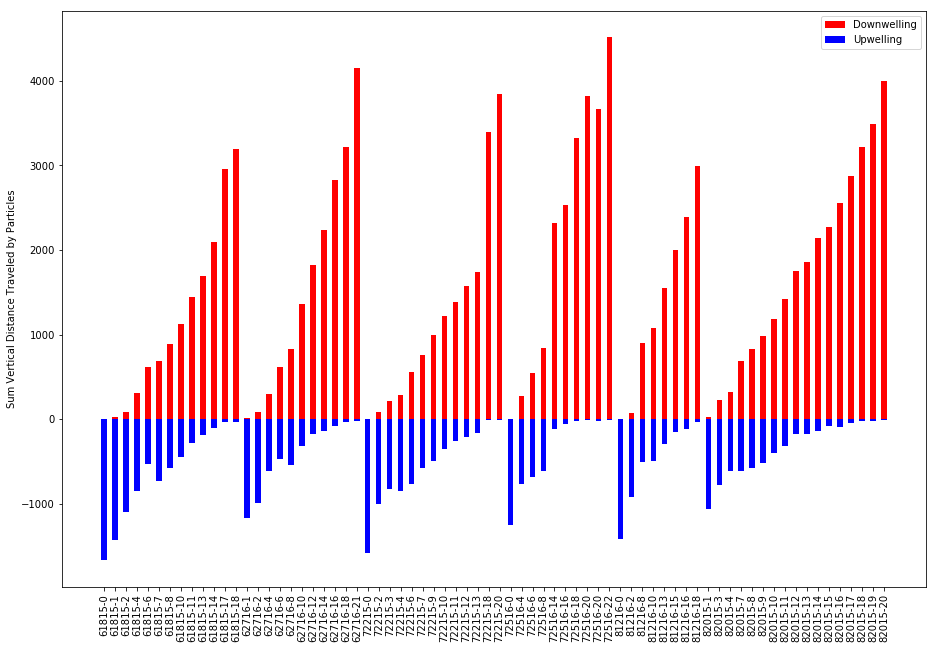

In [9]:
depth_profiles_1516 = pd.concat((particles2015, depth_profiles_2016), axis=0, sort=1, ignore_index=1)
particles1516srt =  depth_profiles_1516.sort_values(by=['DateMMDDYY', 'DepthName'])

#particles2015srt.loc[particles2015srt.index[:20], ['DateMMDDYY', 'DepthName']]

y1 = particles1516srt['sum_upwelling'].values
y2 = particles1516srt['sum_downwelling'].values
xlab  = particles1516srt[['DateMMDDYY', 'DepthName']].apply(lambda x: "-".join([str(int(x[0])), 
                                                                                str(int(x[1]))]), axis=1)

x12 = list(range(1,len(y1)+1))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0,0,1,1])

ax.bar(x12, y2*-1, 0.5, label='Downwelling', bottom=[0]*len(y2), color='r')
ax.bar(x12, y1*-1, 0.5, label='Upwelling', bottom=[0]*len(y2), color='b')
ax.set_ylabel('Sum Vertical Distance Traveled by Particles')
ax.set_xticks(x12)
ax.set_xticklabels(list(xlab), rotation = 90)
#ax.set_yticks(np.arange(0, 81, 10))
ax.legend()
plt.show()


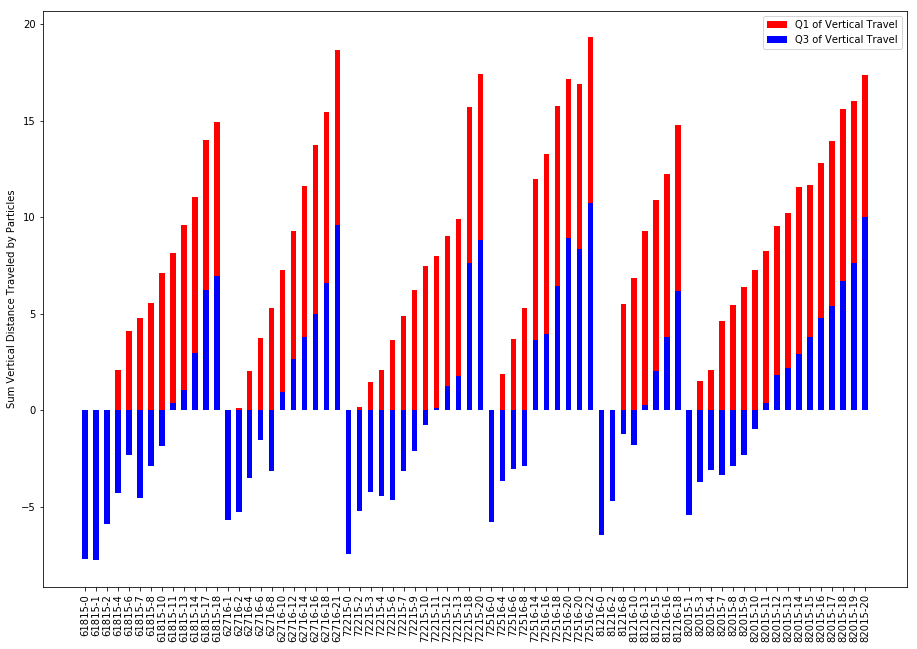

In [10]:

y1 = particles1516srt['up_lim'].values
y2 = particles1516srt['down_lim'].values
xlab  = particles1516srt[['DateMMDDYY', 'DepthName']].apply(lambda x: "-".join([str(int(x[0])), 
                                                                                str(int(x[1]))]), axis=1)

x12 = list(range(1,len(y1)+1))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_axes([0,0,1,1])

ax.bar(x12, y1, 0.5, label='Q1 of Vertical Travel', bottom=[0]*len(y1), color='r')
ax.bar(x12, y2, 0.5, label='Q3 of Vertical Travel', bottom=[0]*len(y2), color='b')
ax.set_ylabel('Sum Vertical Distance Traveled by Particles')
ax.set_xticks(x12)
ax.set_xticklabels(list(xlab), rotation = 90)
#ax.set_yticks(np.arange(0, 81, 10))
ax.legend()
plt.show()


   down_lim  east_lim  north_lim  south_lim    up_lim  west_lim
0 -7.719559  0.045293   0.098697  -0.038035 -2.019791 -0.044348
1 -7.769029  0.053372   0.088490  -0.043114 -1.064991 -0.040470
2 -5.868967  0.037402   0.099464  -0.035119  0.031196 -0.046250
3 -4.305832  0.017245   0.119202  -0.062935  2.099171 -0.052140
4 -2.298908  0.030225   0.071000  -0.115269  4.110483 -0.055283


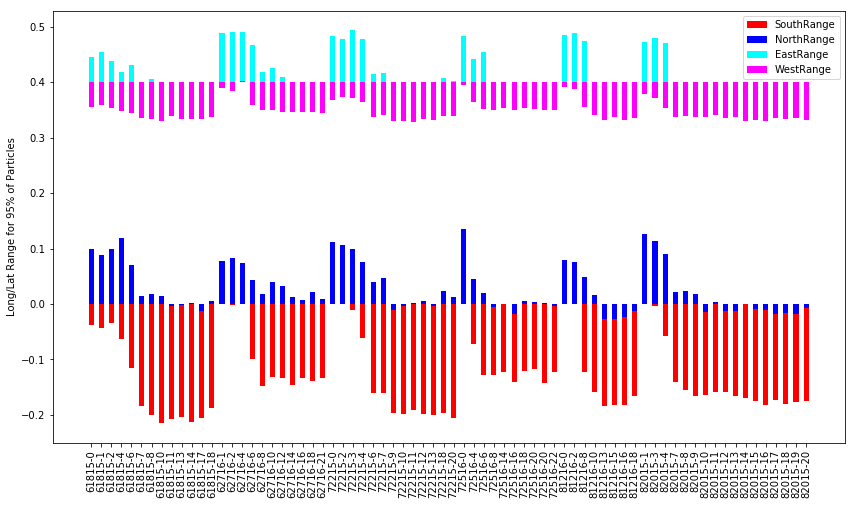

In [11]:
y1 = particles1516srt['south_lim'].values
y2 = particles1516srt['north_lim'].values
y3 = particles1516srt['east_lim'].values
y4 = particles1516srt['west_lim'].values

print(particles1516srt[[i for i in particles1516srt.columns if 'lim' in i]].head())

x12 = list(range(1,len(y1)+1))

fig = plt.figure(figsize=(11, 6))
ax = fig.add_axes([0,0,1,1])

ax.bar(x12, y1, 0.5, label='SouthRange', color='r')
ax.bar(x12, y2, 0.5, label='NorthRange', color='b')
ax.bar(x12, y3, 0.5, label='EastRange', bottom=[0.4]*len(y3), color='cyan')
ax.bar(x12, y4, 0.5, label='WestRange', bottom=[0.4]*len(y4), color='magenta')
ax.set_ylabel('Long/Lat Range for 95% of Particles')
ax.set_xticks(x12)
ax.set_xticklabels(list(xlab), rotation = 90)
#ax.set_yticks(np.arange(0, 81, 10))
ax.legend()
plt.show()
                      

            sum_upwelling            sum_downwelling                 up_lim  \
                     mean        std            mean         std       mean   
StationName                                                                   
CB22             0.409714   0.414936    -2250.703921   20.980775   9.407795   
CB31             0.000000   0.000000    -2750.684838   31.996652  11.176853   
CB32            50.598543        NaN    -1530.728445         NaN   8.073041   
CB33C           11.995468  12.657229    -4121.548118  650.641162  18.346447   
CB41C            0.000000        NaN    -6206.002385         NaN  24.027543   

                        down_lim            
                  std       mean       std  
StationName                                 
CB22         0.069200   5.826557  0.028123  
CB31         0.274937   7.411824  0.062476  
CB32              NaN   1.987387       NaN  
CB33C        2.053749   9.784507  2.108778  
CB41C             NaN  17.147855       NaN  


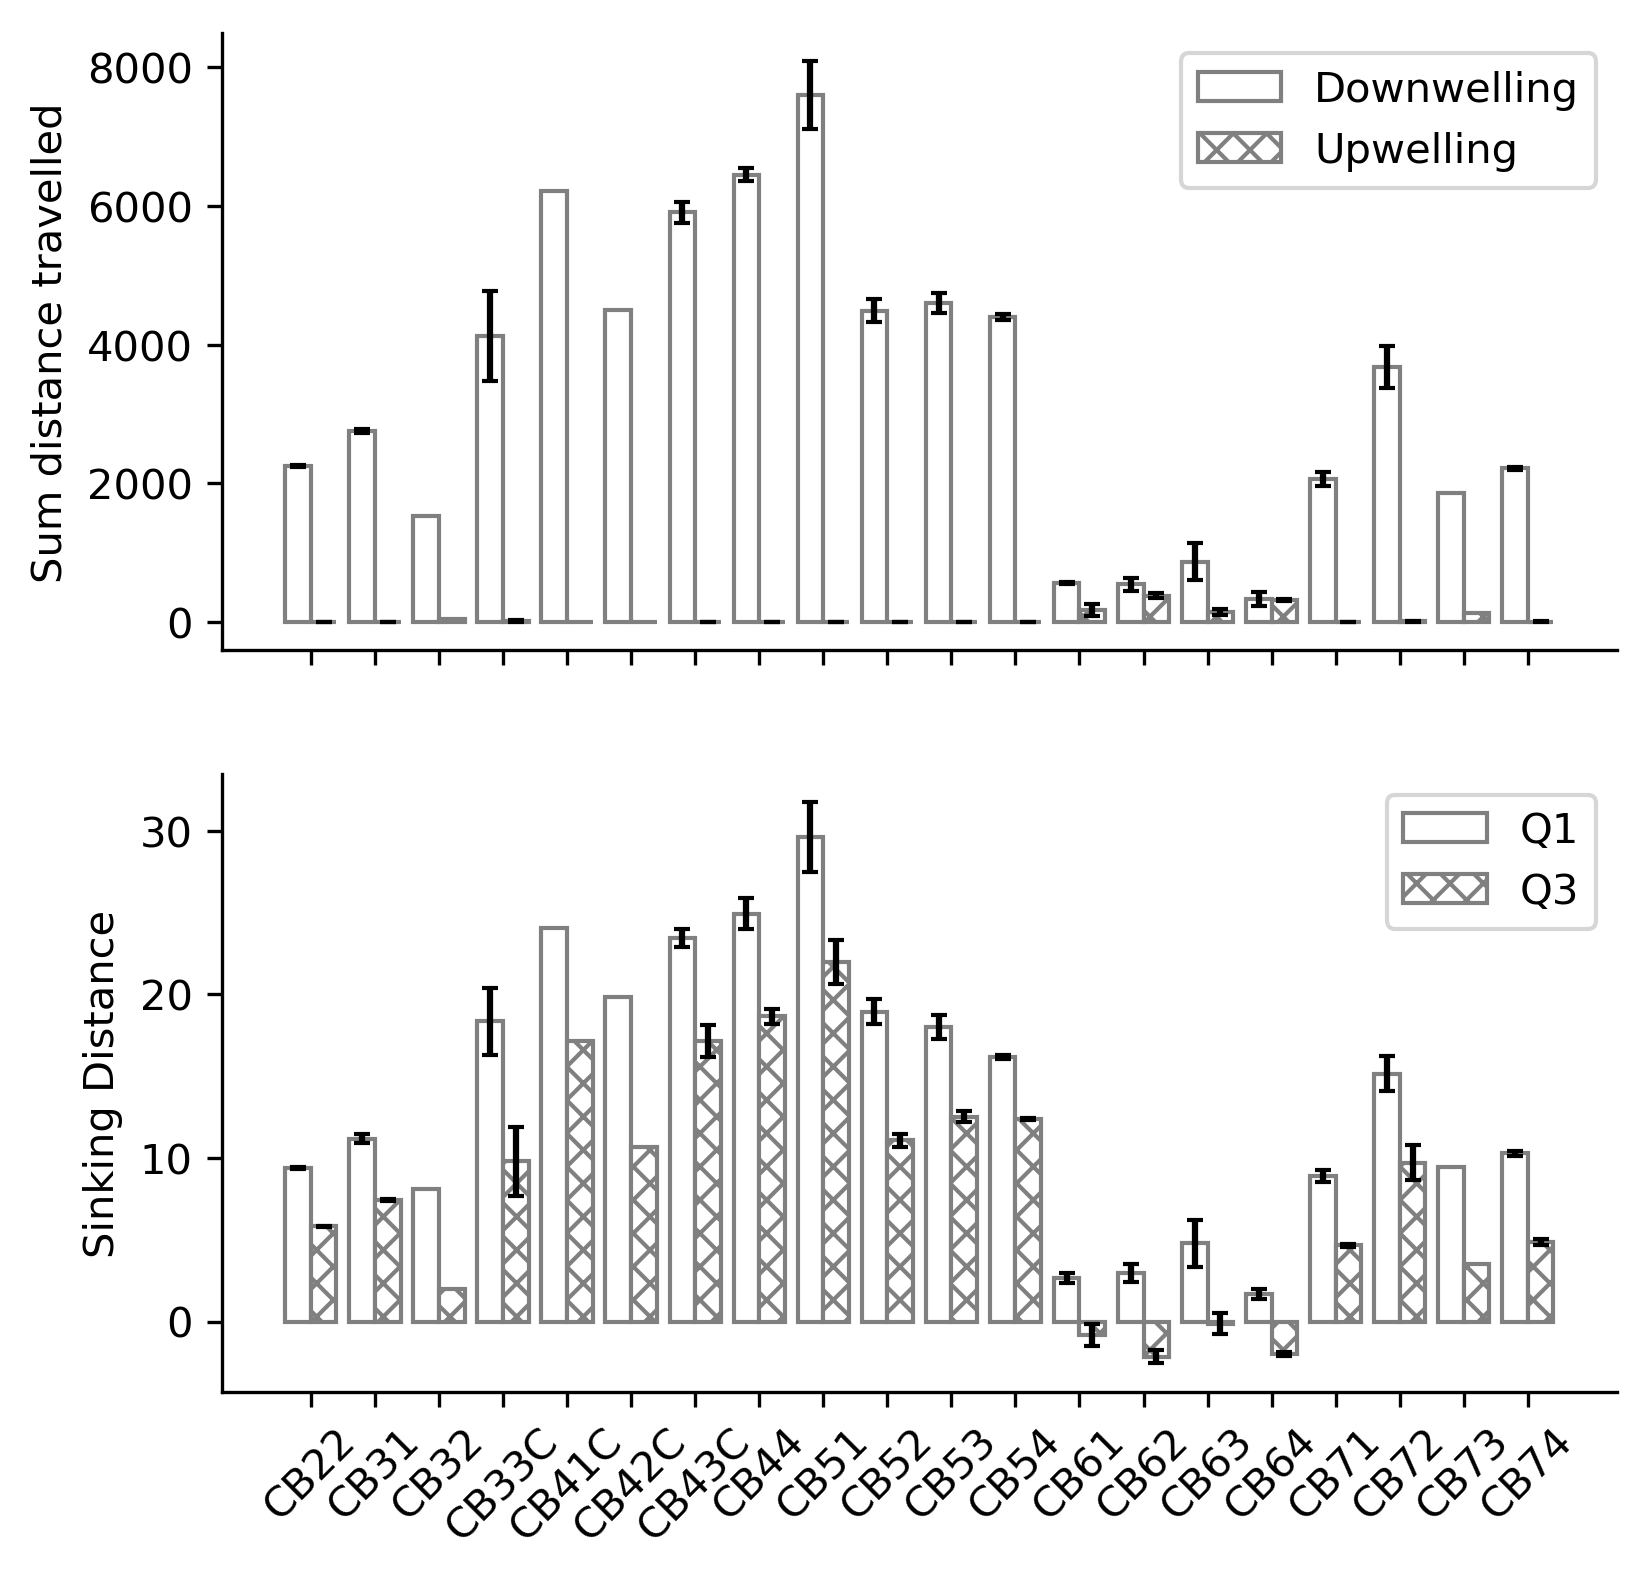

In [12]:
particles2016srt =  particles_transect_2016.sort_values(by=['StationName', 'DateMMDDYY', 'DepthName'])
quant_cols = ['sum_upwelling', 'sum_downwelling', 'up_lim', 'down_lim']

updown_df = particles2016srt.loc[:, quant_cols + ['StationName']].groupby('StationName').agg([np.mean, np.std])
#updown_df = updown_df.fillna(0)
print(updown_df.head())

y1 = updown_df[('sum_upwelling', 'mean')].values
y2 = updown_df[('sum_downwelling', 'mean')].values
y1s = updown_df[('sum_upwelling', 'std')].values
y2s = updown_df[('sum_downwelling', 'std')].values

y3 = updown_df[('up_lim', 'mean')].values
y4 = updown_df[('down_lim', 'mean')].values
y3s = updown_df[('up_lim', 'std')].values
y4s = updown_df[('down_lim', 'std')].values

xlab  = list(updown_df.index)
x12 = np.array(list(range(1,len(y1)+1)))


fig = plt.figure(figsize=(6, 6), dpi=300)
ax1, ax2 = fig.subplots(2, 1, sharex=True)

ax1.bar(x12-0.2, y2*-1, 0.4, label='Downwelling', bottom=[0]*len(y2), color='white', edgecolor='grey',
        yerr=y2s, ecolor='black', capsize=2)
ax1.bar(x12+0.2, y1, 0.4, label='Upwelling', bottom=[0]*len(y2), color='white', edgecolor='grey', hatch='xxx',
        yerr=y1s, ecolor='black', capsize=2)
ax1.set_ylabel('Sum distance travelled')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticks(x12)
ax1.set_xticklabels(list(xlab), rotation = 45)
#ax1.tick_params(bottom=False, top=False, left=True, right=False, 
#                labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax1.legend()
ax2.bar(x12-0.2, y3, 0.4, label='Q1', bottom=[0]*len(y3), color='white', edgecolor='grey',
        yerr=y3s, ecolor='black', capsize=2)
ax2.bar(x12+0.2, y4, 0.4, label='Q3', bottom=[0]*len(y4), color='white', edgecolor='grey', hatch='xxx',
        yerr=y4s, ecolor='black', capsize=2)
ax2.set_ylabel('Sinking Distance')
ax2.set_xticks(x12)
ax2.set_xticklabels(list(xlab), rotation = 45)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend()
plt.show()


            south_lim           north_lim            east_lim            \
                 mean       std      mean       std      mean       std   
StationName                                                               
CB22        -0.026336  0.037176  0.018708  0.016561  0.019743  0.020816   
CB31        -0.010037  0.015760  0.046210  0.020859  0.030446  0.003495   
CB32        -0.089285       NaN -0.024850       NaN  0.016768       NaN   
CB33C       -0.165801  0.038146 -0.024460  0.031333 -0.017666  0.006787   
CB41C       -0.268943       NaN -0.127538       NaN -0.016317       NaN   

             west_lim            
                 mean       std  
StationName                      
CB22        -0.026793  0.027671  
CB31        -0.020550  0.003246  
CB32        -0.026538       NaN  
CB33C       -0.063863  0.010697  
CB41C       -0.063792       NaN  


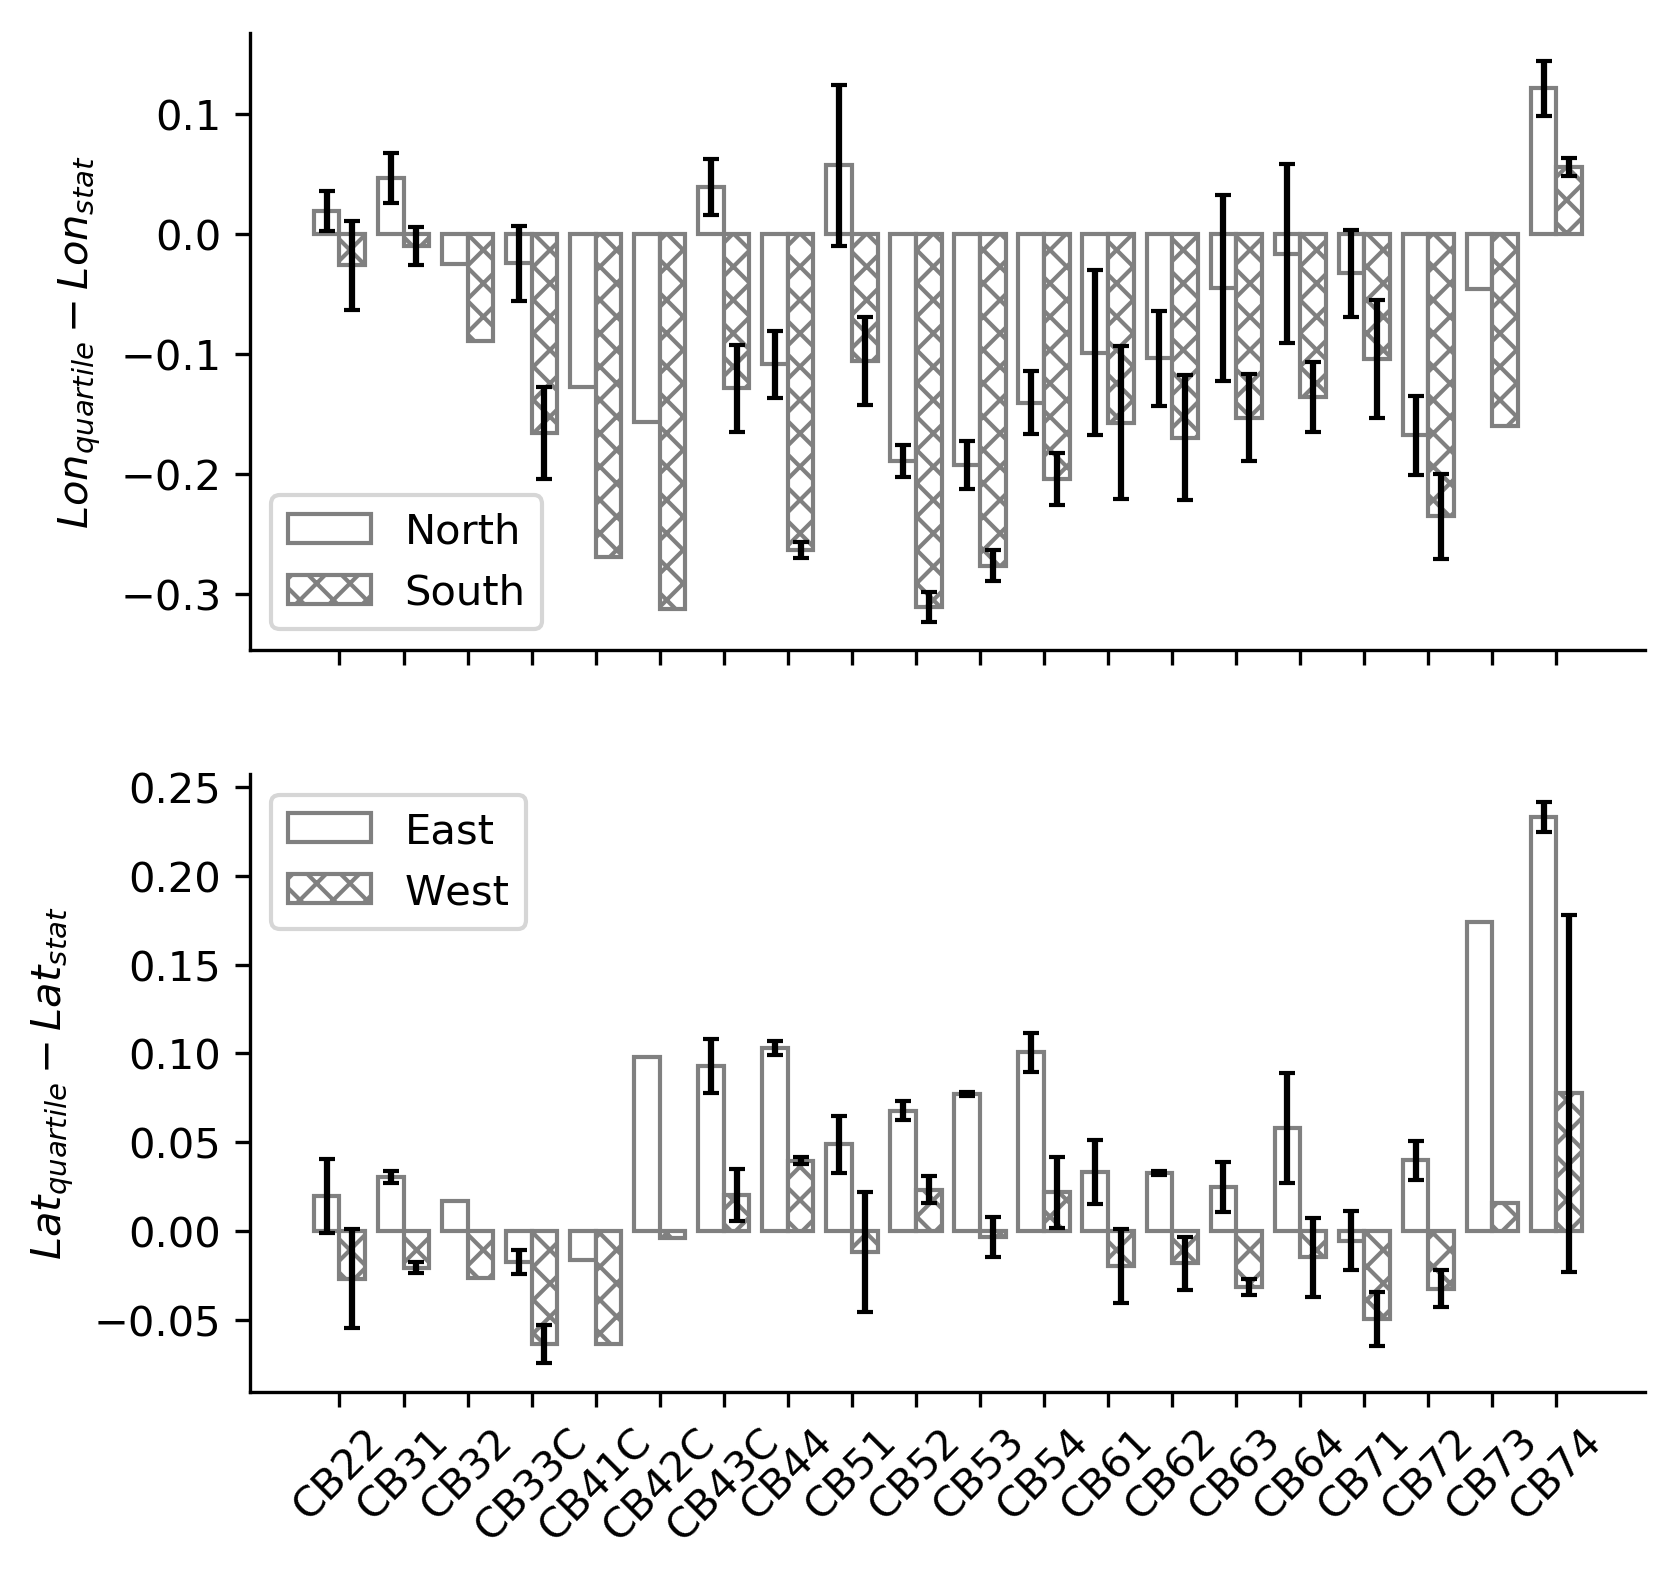

In [13]:
quant_cols = ['south_lim', 'north_lim', 'east_lim', 'west_lim']
allround_df = particles2016srt.loc[:, quant_cols + ['StationName']].groupby('StationName').agg([np.mean, np.std])
print(allround_df.head())

y1 = allround_df[('south_lim', 'mean')].values
y2 = allround_df[('north_lim', 'mean')].values
y1s = allround_df[('south_lim', 'std')].values
y2s = allround_df[('north_lim', 'std')].values

y3 = allround_df[('east_lim', 'mean')].values
y4 = allround_df[('west_lim', 'mean')].values
y3s = allround_df[('east_lim', 'std')].values
y4s = allround_df[('west_lim', 'std')].values

xlab  = list(allround_df.index)
x12 = np.array(list(range(1,len(y1)+1)))


fig = plt.figure(figsize=(6, 6), dpi=300)
ax1, ax2 = fig.subplots(2, 1, sharex=True)

ax1.bar(x12-0.2, y2, 0.4, label='North', bottom=[0]*len(y2), color='white', edgecolor='grey',
        yerr=y2s, ecolor='black', capsize=2)
ax1.bar(x12+0.2, y1, 0.4, label='South', bottom=[0]*len(y2), color='white', edgecolor='grey', hatch='xxx',
        yerr=y1s, ecolor='black', capsize=2)
ax1.set_ylabel(r'$Lon_{quartile} - Lon_{stat}$')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticks(x12)
ax1.set_xticklabels(list(xlab), rotation = 45)
#ax1.tick_params(bottom=False, top=False, left=True, right=False, 
#                labelbottom=False, labeltop=False, labelleft=True, labelright=False)
ax1.legend()
ax2.bar(x12-0.2, y3, 0.4, label='East', bottom=[0]*len(y3), color='white', edgecolor='grey',
        yerr=y3s, ecolor='black', capsize=2)
ax2.bar(x12+0.2, y4, 0.4, label='West', bottom=[0]*len(y4), color='white', edgecolor='grey', hatch='xxx',
        yerr=y4s, ecolor='black', capsize=2)
ax2.set_ylabel(r'$Lat_{quartile} - Lat_{stat}$')
ax2.set_xticks(x12)
ax2.set_xticklabels(list(xlab), rotation = 45)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.legend()
plt.show()


In [14]:
env_data['StatName'] = pd.Series()
statg1 = ['CB22', 'CB31', 'CB32']
statg2 = ['CB33C', 'CB41C']
statg3 = ['CB42C', 'CB43C', 'CB44', 'CB51']
statg4 = ['CB52', 'CB53', 'CB54', 'CB71']
statg5 = ['CB61', 'CB62', 'CB63', 'CB64']
statg6 = ['CB72', 'CB73', 'CB74']

env_data.loc[env_data['StationName'].isin(statg1),'StatName'] = 1
env_data.loc[env_data['StationName'].isin(statg2),'StatName'] = 2
env_data.loc[env_data['StationName'].isin(statg3),'StatName'] = 3
env_data.loc[env_data['StationName'].isin(statg4),'StatName'] = 4
env_data.loc[env_data['StationName'].isin(statg5),'StatName'] = 5
env_data.loc[env_data['StationName'].isin(statg6),'StatName'] = 6

statdat = env_data[['StationName', 'StatName', 'Latitude', 'Longitude']].groupby('StationName').agg(['mean', 'count'])
statdat.columns = statdat.columns.droplevel()

statdat.columns = ['StationGroup', 'NumSamples', 'Lat', 'x', 'Lon', 'y']
statdat.drop(['x', 'y'], axis=1, inplace=True)
statdat

,StationGroup,NumSamples,Lat,Lon
StationName,,,,
CB22,1.0,9,39.348730,-76.175790
CB31,1.0,9,39.249500,-76.240500
CB32,1.0,7,39.163690,-76.306310
CB33C,2.0,101,38.997656,-76.359233
CB41C,2.0,2,38.825930,-76.399450
CB42C,3.0,8,38.646180,-76.421270
CB43C,3.0,11,38.555050,-76.427940
CB44,3.0,15,38.414570,-76.345650
CB51,3.0,9,38.318700,-76.292150


Group 1 : ['CB22', 'CB31', 'CB32']
Row #s: [3311, 10535, 10836, 11137, 11438, 11739]
N particles: 1800
Group 2 : ['CB33C', 'CB41C']
Row #s: [3010, 6321, 6622, 14147, 14448, 14749]
N particles: 1800
Group 3 : ['CB42C', 'CB43C', 'CB44', 'CB51']
Row #s: [6923, 7224, 7525, 15351, 15652, 15953, 16254, 16555]
N particles: 2400
Group 4 : ['CB52', 'CB53', 'CB54', 'CB71']
Row #s: [7826, 8127, 8428, 8729, 16856, 17157, 17458, 17759, 18060, 18361, 18662]
N particles: 3300
Group 5 : ['CB61', 'CB62', 'CB63', 'CB64']
Row #s: [9030, 9331, 9933, 18963, 19264, 19565, 19866, 20167, 20468, 21371, 21672]
N particles: 3300
Group 6 : ['CB72', 'CB73', 'CB74']
Row #s: [9632, 10234, 20769, 21070, 21973, 22274]
N particles: 1800


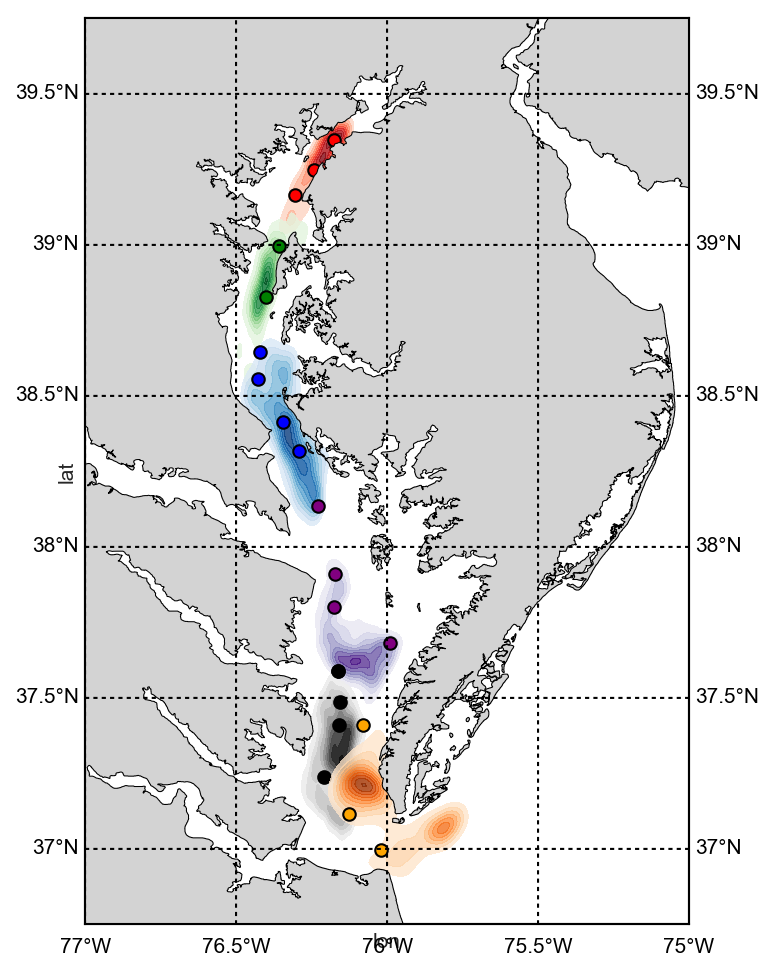

In [15]:
all_particles = pd.concat(particle_chunks16.values(), axis=0, sort=True, verify_integrity=True)
#ap_m = all_particles[['lat', 'lon']].mean()
#ap_sd = all_particles[['x_km', 'y_km']].std()


part_data = {}
for stat_group_i in statdat.StationGroup.unique():
    stat_group_names = list(statdat[statdat.StationGroup == stat_group_i].index)
    stat_group_bool = particles_transect_2016.StationName.isin(stat_group_names)
    stat_group_ixs = list(particles_transect_2016[stat_group_bool].index)
    print("Group", int(stat_group_i), ":", stat_group_names)
    print("Row #s:", stat_group_ixs)

    stat_grp_particles = pd.concat([particle_chunks16[i] for i in stat_group_ixs], 
                                    axis=0, sort=True, verify_integrity=True)

    print("N particles:", len(stat_grp_particles))
    x_pos = stat_grp_particles['lat']# - ap_m['lat']) #/ap_sd['x_km']
    y_pos = stat_grp_particles['lon']# - ap_m['lon']) #/ap_sd['y_km']
    xy_vec = np.sqrt(x_pos**2 + y_pos**2)
    dist_lims = np.percentile(xy_vec, [5, 95])
    x_pos = x_pos[(xy_vec > dist_lims[0]) & (xy_vec < dist_lims[1])]
    y_pos = y_pos[(xy_vec > dist_lims[0]) & (xy_vec < dist_lims[1])]
    part_data[int(stat_group_i)] = {'x': x_pos, 'y': y_pos, 
                               'sx': statdat.loc[stat_group_names, 'Lat'],
                               'sy': statdat.loc[stat_group_names, 'Lon'],
                               'l': "Group{}".format(int(stat_group_i))}

import seaborn as sns
np.random.seed(10)
sns.set_style("whitegrid")

#sns.set(color_codes=True, font_scale=1)
kde_f, kde_ax = plt.subplots(figsize=(6,8), dpi=150)
#kde_ax.tick_params(axis='both', which='major', labelsize=22)
ax1 = sns.kdeplot(part_data[1]['y'], part_data[1]['x'], cmap="Reds", shade=True, shade_lowest=False, 
                  alpha=0.8, ax=kde_ax)
kde_ax.scatter(x=part_data[1]['sy'], y=part_data[1]['sx'], c='red', edgecolors='k')

ax2 = sns.kdeplot(part_data[2]['y'], part_data[2]['x'], cmap="Greens", shade=True, shade_lowest=False, 
                  alpha=0.8, ax=kde_ax)
kde_ax.scatter(x=part_data[2]['sy'], y=part_data[2]['sx'], c='green', edgecolors='k')

ax3 = sns.kdeplot(part_data[3]['y'], part_data[3]['x'], cmap="Blues", shade=True, shade_lowest=False, 
                  alpha=0.8, ax=kde_ax)
kde_ax.scatter(x=part_data[3]['sy'], y=part_data[3]['sx'], c='blue', edgecolors='k')

ax4 = sns.kdeplot(part_data[4]['y'], part_data[4]['x'], cmap="Purples", shade=True, shade_lowest=False, 
                  alpha=0.8, ax=kde_ax)
kde_ax.scatter(x=part_data[4]['sy'], y=part_data[4]['sx'], c='purple', edgecolors='k')

ax5 = sns.kdeplot(part_data[5]['y'], part_data[5]['x'], cmap="Greys", shade=True, shade_lowest=False, 
                  alpha=0.8, ax=kde_ax)
kde_ax.scatter(x=part_data[5]['sy'], y=part_data[5]['sx'], c='k', edgecolors='k')

ax5 = sns.kdeplot(part_data[5]['y'], part_data[5]['x'], cmap="Greys", shade=True, shade_lowest=False, 
                  alpha=0.8, ax=kde_ax)
kde_ax.scatter(x=part_data[5]['sy'], y=part_data[5]['sx'], c='k', edgecolors='k')

ax6 = sns.kdeplot(part_data[6]['y'], part_data[6]['x'], cmap="Oranges", shade=True, shade_lowest=False, 
                  alpha=0.8, ax=kde_ax)
kde_ax.scatter(x=part_data[6]['sy'], y=part_data[6]['sx'], c='orange', edgecolors='k')

#kde_ax.spines['right'].set_visible(False)
#kde_ax.spines['top'].set_visible(False)
kde_ax.set_xlim((-77, -75))
kde_ax.set_ylim((36.75, 39.75))


m2 = Basemap(llcrnrlat=36.75,urcrnrlat=39.75,llcrnrlon=-77,urcrnrlon=-75, resolution='f', ax=kde_ax)
m2.drawcoastlines(linewidth=0.5)
m2.fillcontinents(color='lightgrey',lake_color='white')
m2.drawparallels(np.arange(36.5,40,0.5), labels=[True,True,False,False], dashes=[2,2])
m2.drawmeridians(np.arange(-78.,-74,0.5), labels=[False,False,False,True], dashes=[2,2])
m2.drawmapboundary(fill_color='white')

plt.show()


In [16]:
f = "~/Google Drive/SiYi_Xiaotong_Materials/bray_curtis_betadiversity.txt"
bd_df = pd.read_csv(f, sep="\t", index_col=0)
bd_df.columns = [i.replace("_wu", "") for i in bd_df.columns]

sn_df = pd.DataFrame(index=list(range(1,7)),
                     columns=list(range(1,7)))

for i in sn_df.index:
    for j in sn_df.index:
        clust_ixs = env_data[env_data.StatName == i].index
        clust_jxs = env_data[env_data.StatName == j].index
        sn_df.loc[i, j] = bd_df.loc[clust_ixs, clust_jxs].mean().mean()

score_c =  []
for i in sn_df.index:
    v = sn_df.iloc[i-1, i-1]
    j = list(sn_df.iloc[i-1,:])
    j.remove(v)
    l = min(j)
    print(i, round(v/l, 3))
    score_c.append(v/l)
    
print(sum(score_c))  

1 0.872
2 1.026
3 0.948
4 0.994
5 0.977
6 0.922
5.739730923390547


In [ ]:
# ['CB72', 'CB73', 'CB74'] 5.739730923390547
#['CB63', 'CB73', 'CB74'] : 5.811574898837427
#73 and 74 alone : 5.713039267650133

In [36]:
import matplotlib as mpl
print(particles2016.DateMMDDYY.unique())
date_range = ['71316', '71116', '71216']
sub2016_1 = particles_transect_2016[particles_transect_2016.DateMMDDYY.isin(date_range)]
station_set_3 = list(particles_transect_2016.StationName.unique())

sub2016_jul = sub2016_1[sub2016_1.StationName.isin(station_set_3)]

date_range_2 = ['81016', '81216', '80816', '80916']
sub2016_2 = particles_transect_2016[particles_transect_2016.DateMMDDYY.isin(date_range_2)]
sub2016_aug = sub2016_2[sub2016_2.StationName.isin(station_set_3)]
mlp_colors = list(mpl.rcParams['axes.prop_cycle']) * 5



[62716. 71316. 72516. 71216. 71116. 81016. 83116. 81216. 80916. 83016.
 82916. 80816.]


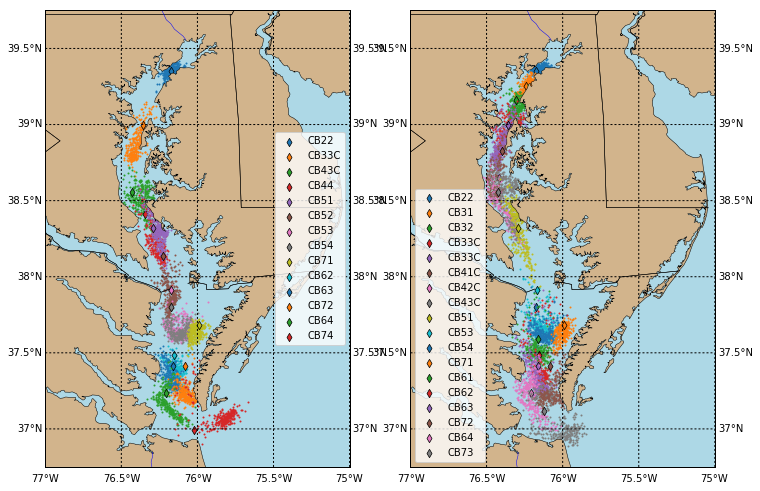

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 10), dpi=150)
m = Basemap(llcrnrlat=36.75,urcrnrlat=39.75,llcrnrlon=-77,urcrnrlon=-75, resolution='h', ax=axes[0])
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='tan',lake_color='lightblue')
# draw parallels and meridians.
m.drawparallels(np.arange(36.5,40,0.5),labels=[True,True,False,False], dashes=[2,2])
m.drawmeridians(np.arange(-78.,-74,0.5), labels=[False,False,False,True], dashes=[2,2])
m.drawmapboundary(fill_color='lightblue')
m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
m.drawstates(linewidth=0.5, linestyle='solid', color='k')
m.drawrivers(linewidth=0.5, linestyle='solid', color='blue')

for idx_ in range(len(sub2016_jul)):
    this_col = mlp_colors[idx_]['color']
    idx_no = sub2016_jul.index[idx_]
    statname = sub2016_jul.loc[idx_no, 'StationName']
    m.scatter(x=particle_chunks16[idx_no]['lon'], 
              y=particle_chunks16[idx_no]['lat'], s=1, c=this_col, label=None)
    m.scatter(x = stat_latlon.loc[statname, 'Longitude'], 
              y = stat_latlon.loc[statname, 'Latitude'], 
              s=35, marker='d', edgecolor='k', linewidths=0.7, c=this_col, label=statname)

m2 = Basemap(llcrnrlat=36.75,urcrnrlat=39.75,llcrnrlon=-77,urcrnrlon=-75, resolution='h', ax=axes[1])
m2.drawcoastlines(linewidth=0.5)
m2.fillcontinents(color='tan',lake_color='lightblue')
m2.drawparallels(np.arange(36.5,40,0.5), labels=[True,True,False,False], dashes=[2,2])
m2.drawmeridians(np.arange(-78.,-74,0.5), labels=[False,False,False,True], dashes=[2,2])
m2.drawmapboundary(fill_color='lightblue')
m2.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
m2.drawstates(linewidth=0.5, linestyle='solid', color='k')
m2.drawrivers(linewidth=0.5, linestyle='solid', color='blue')
for idx_ in range(len(sub2016_aug)):
    this_col = mlp_colors[idx_]['color']
    idx_no = sub2016_aug.index[idx_]
    statname = sub2016_aug.loc[idx_no, 'StationName']
    m2.scatter(x=particle_chunks16[idx_no]['lon'], 
               y=particle_chunks16[idx_no]['lat'], s=1, c=this_col, label=None)
    m2.scatter(x = stat_latlon.loc[statname, 'Longitude'], 
              y = stat_latlon.loc[statname, 'Latitude'], 
              s=35, marker='d', edgecolor='k', linewidths=0.7, c=this_col, label=statname)

axes[0].legend()
axes[1].legend()

In [38]:
outp = '/Volumes/KeithSSD/CB_V4/otu_data/mixing_data'
outf = "2016_transect_mixing_data_products.txt"
particles_transect_2016.to_csv(os.path.join(outp, outf), sep="\t")


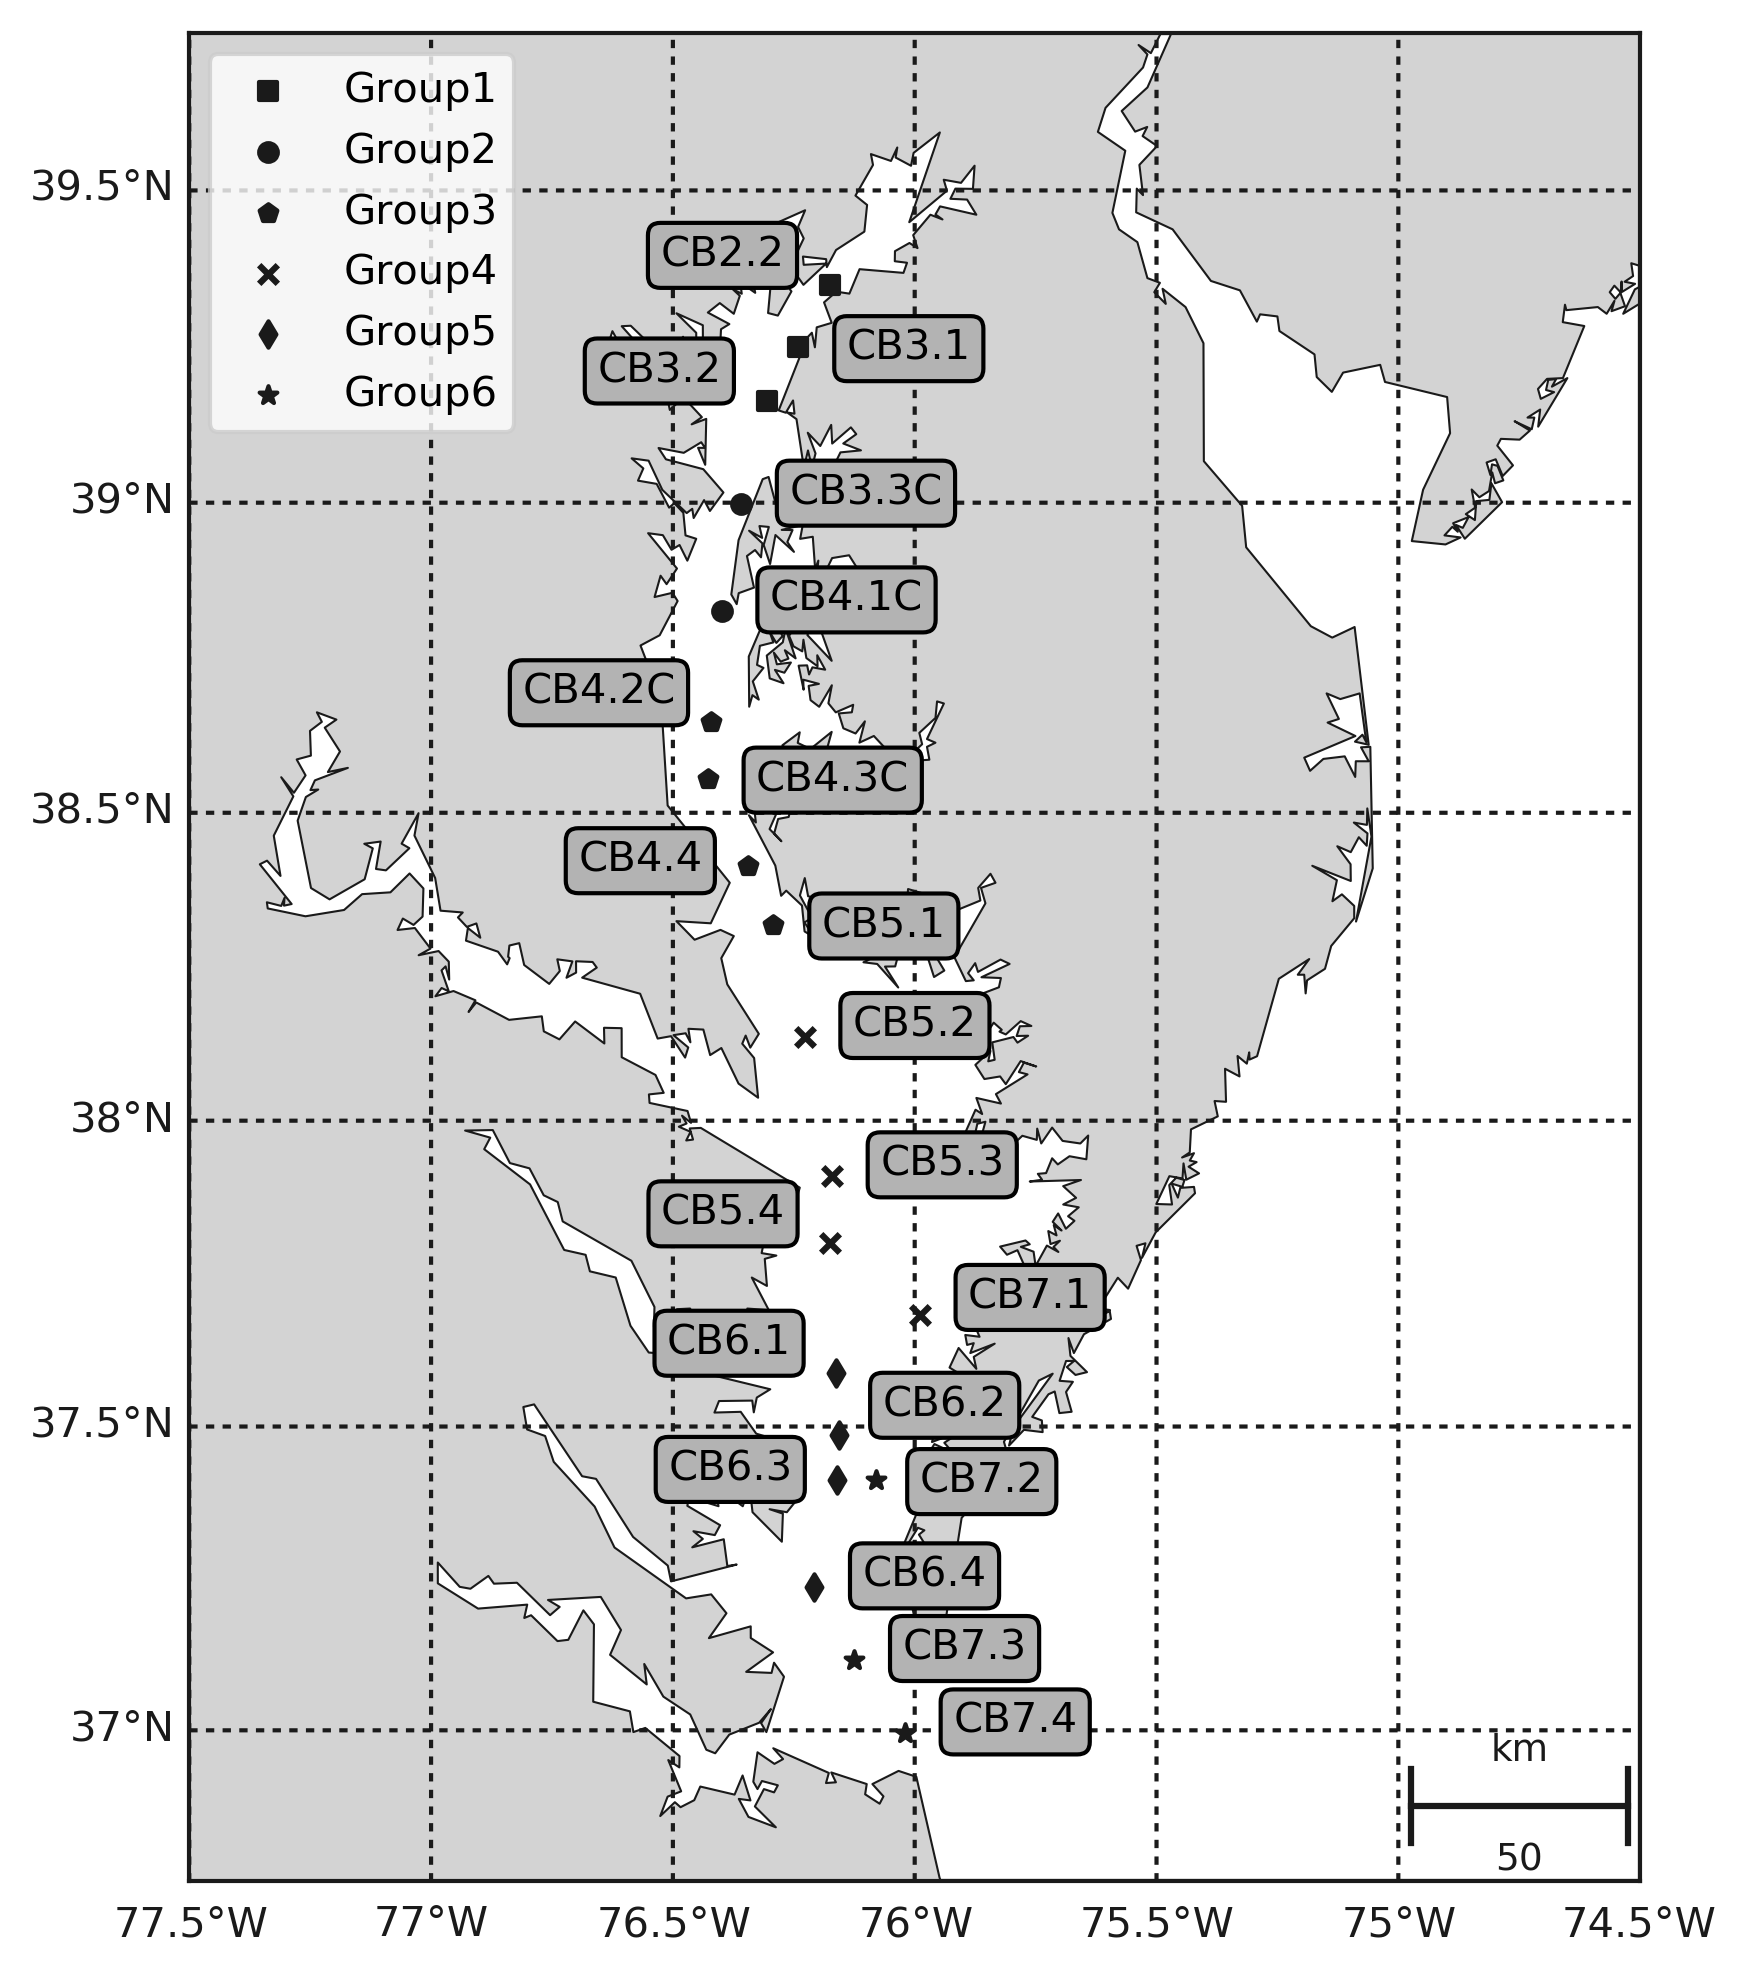

In [194]:
mpl.rcParams.update(mpl.rcParamsDefault)

font = {'size': 10}

mpl.rc('font', **font)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 8), dpi=300)
m = Basemap(llcrnrlat=36.75,urcrnrlat=39.75,llcrnrlon=-77.5,urcrnrlon=-74.5, resolution='i', ax=axes,
           projection='merc')
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='lightgrey',lake_color='white')
m.drawparallels(np.arange(36.5,40,0.5),labels=[True,False,False,False], dashes=[2,2])
m.drawmeridians(np.arange(-78.,-74,0.5), labels=[False,False,False,True], dashes=[2,2])
m.drawmapboundary(fill_color='white')
#m.drawcountries(linewidth=1.5, linestyle='solid', color='k' ) 
#m.drawstates(linewidth=1.5, linestyle='solid', color='k')
#m.drawrivers(linewidth=2, linestyle='solid', color='white')
m.drawmapscale(lon=-74.75, lat=36.875, lon0=-75.25, lat0=36.875, length=50)

marker_list = ['s', 'o', 'p', 'x', 'd', '*']
for idx_ in statdat.StationGroup.unique():
    this_col = mlp_colors[int(idx_)]['color']
    substat = statdat[statdat.StationGroup == idx_].copy()
    subx, suby = m(substat['Lon'].values, substat['Lat'].values)
    m.scatter(x=subx, y=suby, s=20, c='k', label="Group"+str(int(idx_)),
              marker=marker_list[int(idx_)-1], zorder=10)

bbox_args = dict(boxstyle="round", fc="0.7")
for row in statdat.index:
    rownew = row[:3] + '.' + row[3:]
    realx, realy = statdat['Lon'][row], statdat['Lat'][row]
    
    if row == 'CB63':
        subx, suby = m(realx-0.35, realy)
    elif row in ['CB22', 'CB32', 'CB54', 'CB61']:
        subx, suby = m(realx-0.35, realy+0.03)
    elif row in ['CB44']:
        subx, suby = m(realx-0.35, realy-0.01)
    elif row in ['CB42C']:
        subx, suby = m(realx-0.39, realy+0.03)
    elif row in ['CB31']:
        subx, suby = m(realx+0.1, realy-0.02)
    elif row in ['CB32', 'CB43C', 'CB51']:
        subx, suby = m(realx+0.1, realy-0.02)
    elif row in ['CB71']:
        subx, suby = m(realx+0.1, realy+0.01)
    elif row in ['CB72']:
        subx, suby = m(realx+0.09, realy-0.02)
    elif row in ['CB62']:
        subx, suby = m(realx+0.09, realy+0.03)
    else:
        subx, suby = m(realx+0.1, realy)
    
    allnotes = "{}, n={}".format(rownew, int(statdat['NumSamples'][row]))
    axes.annotate(rownew, (subx, suby), bbox=bbox_args, size=10)
    
axes.legend()
plt.show()

1 0.872
2 1.026
3 0.948
4 0.994
5 0.977
6 0.922


In [191]:
import numpy as np

import pandas
import matplotlib.pyplot as plt
from matplotlib import rcParams



rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

plt.ioff()


mean, cov = [0, 2], [(2, 1), (.5, 1)]
x1, y1 = np.random.multivariate_normal(mean, cov, size=50).T

mean, cov = [5, 7], [(3, 2), (7, 1)]
x2, y2 = np.random.multivariate_normal(mean, cov, size=50).T



plt.xlabel("foo", fontsize=22)
plt.ylabel("bar", fontsize=22)
plt.savefig("foo_vs_bar.png")

5.787
5.739
